In [1]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

### Data Extraction (from Alpha Vantage via their API)

For this project, I'll be using the American Airlines stock market prices from the past 20 years to make my predictions. The specific reason I picked this company over others is that it is bursting with different stock price behaviors over time. This will make the learning more robust and let us test how good the predictions are for a variety of situations.

Since stock prices come in several different flavors, we'll save them accordingly as:

- Open: Opening stock price of the day
- Close: Closing stock price of the day
- High: Highest stock price of the data
- Low: Lowest stock price of the day

In [2]:
api_key = 'LOC9YBYQ9T5BT0AL'

# American Airlines stock market prices
ticker = "AAL"

# JSON file with all the stock market data for AAL from the last 20 years
url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

# Save data to this file
file_to_save = 'stock_market_data-%s.csv'%ticker

# If you haven't already saved data,
# grab the data from the url and store date, low, high, volume, close, open values to a Pandas DataFrame
if not os.path.exists(file_to_save):
    with urllib.request.urlopen(url_string) as url:
        data = json.loads(url.read().decode())
        # extract stock market data
        data = data['Time Series (Daily)']
        df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
        for k,v in data.items():
            date = dt.datetime.strptime(k, '%Y-%m-%d')
            data_row = [date.date(),float(v['3. low']),float(v['2. high']), float(v['4. close']),float(v['1. open'])]
            df.loc[-1,:] = data_row
            df.index = df.index + 1
    print('Data saved to : %s'%file_to_save)        
    df.to_csv(file_to_save)
else:
    print('File already exists. Loading data from CSV')
    df = pd.read_csv(file_to_save)

File already exists. Loading data from CSV


### Data Exploration

In [3]:
# Sort DataFrame by date
df = df.sort_values('Date')

# Double check the result
df.head()

,Unnamed: 0,Date,Low,High,Close,Open
4894,0,2005-09-27,19.10,21.40,19.30,21.05
4893,1,2005-09-28,19.20,20.53,20.50,19.30
4892,2,2005-09-29,20.10,20.58,20.21,20.40
4891,3,2005-09-30,20.18,21.05,21.01,20.26
4890,4,2005-10-03,20.90,21.75,21.50,20.90


### Data Vizualization

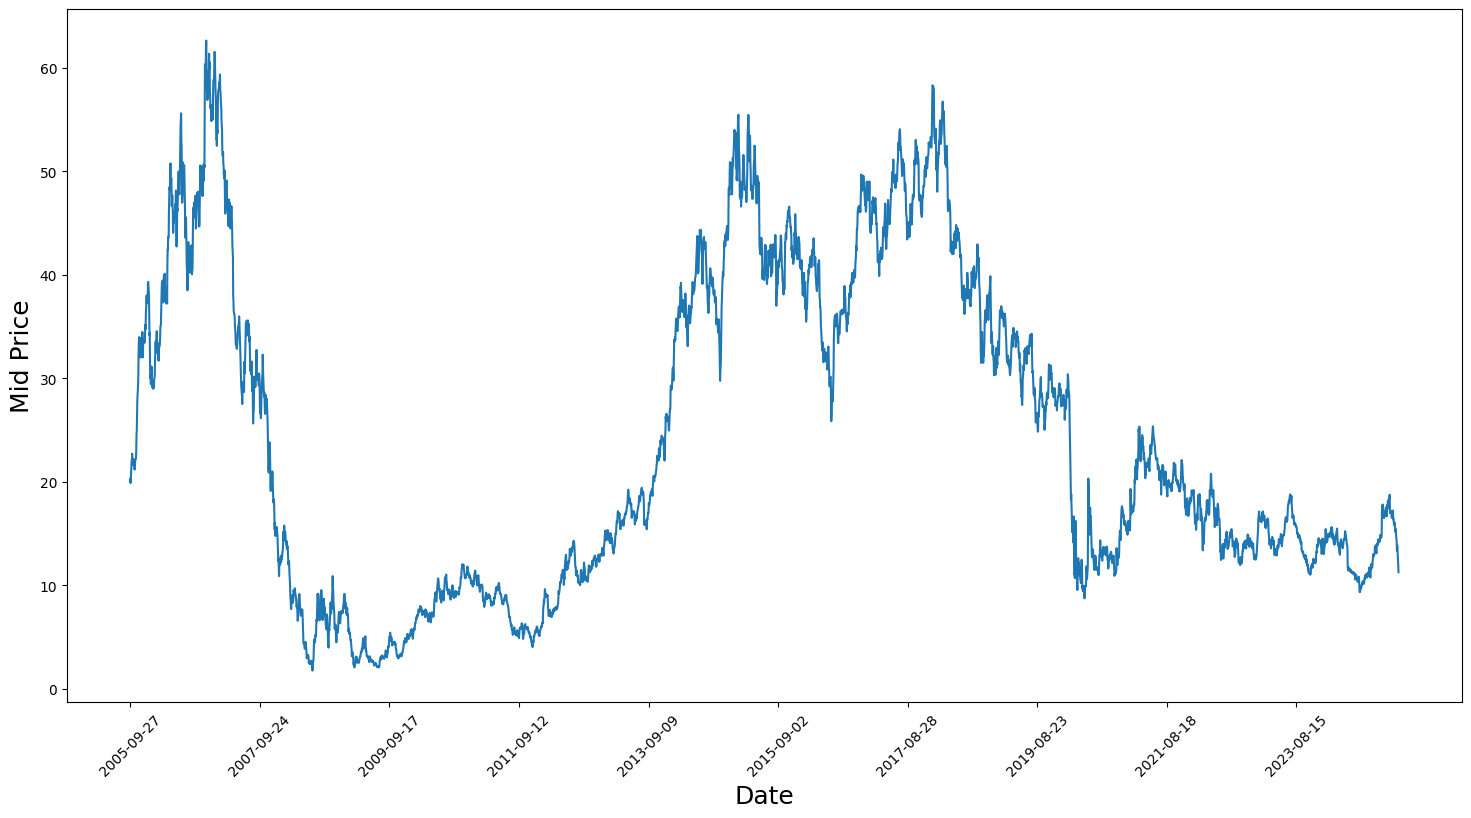

In [4]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

### Splitting the data into training and testing sets

In [5]:
# Calculate mid prices using pandas operations
df['Mid'] = (df['High'] + df['Low']) / 2.0

# Split data into train (80%) and test (20%) sets
total_rows = len(df)
train_size = int(0.8 * total_rows)

train_data = df['Mid'].iloc[:train_size].values
test_data = df['Mid'].iloc[train_size:].values

print(f"Training set size: {len(train_data)} days")
print(f"Test set size: {len(test_data)} days")

Training set size: 3916 days
Test set size: 979 days


### Data Normalization


In [6]:
# Scale the data to be between 0 and 1
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [7]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 500
for di in range(0, len(train_data), smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size])
    train_data[di:di+smoothing_window_size] = scaler.transform(train_data[di:di+smoothing_window_size])

# Normalize the last bit of remaining data
if di + smoothing_window_size < len(train_data):
    scaler.fit(train_data[di+smoothing_window_size:])
    train_data[di+smoothing_window_size:] = scaler.transform(train_data[di+smoothing_window_size:])

In [8]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data using the last fitted scaler
test_data = scaler.transform(test_data).reshape(-1)

In [9]:
# Now perform exponential moving average smoothing
EMA = 0.0
gamma = 0.1
for ti in range(len(train_data)):
    EMA = gamma * train_data[ti] + (1 - gamma) * EMA
    train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data, test_data], axis=0)

### One-Step Ahead Prediction via Averaging

Averaging mechanisms allow us to predict by representing the future stock price as an average of the previously observed stock prices. Since doing this for more than one time step can produce quite bad results, we will look at two averaging techniques: below standard averaging and exponential moving average. We will evaluate both qualitatively (visual inspection) and quantitatively (Mean Squared Error) the results produced by the two algorithms.

The Mean Squared Error (MSE) can be calculated by taking the Squared Error between the true value at one step ahead and the predicted value and averaging it over all the predictions.

In [10]:
# Standard Average

window_size = 50
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00723


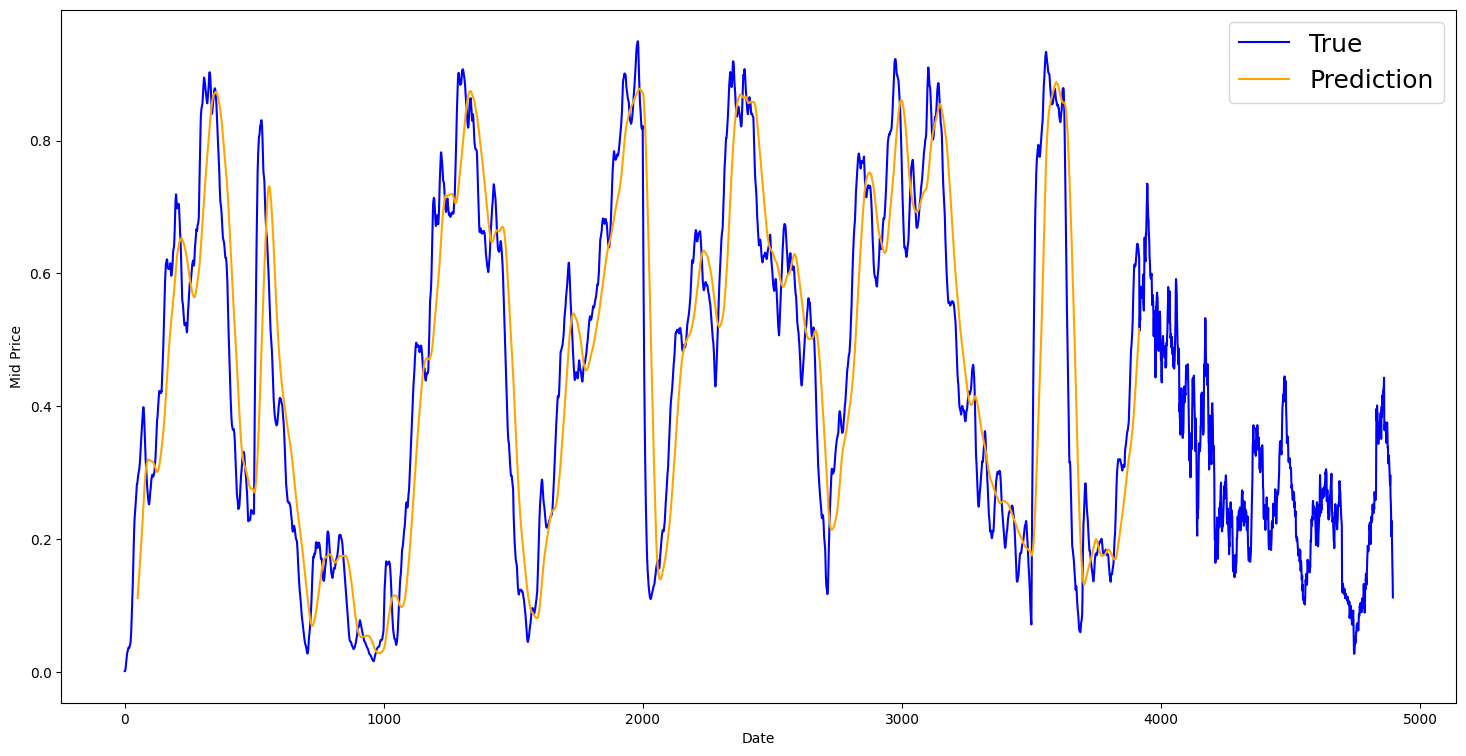

In [11]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [12]:
# Exponential moving average

window_size = 50
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))


MSE error for EMA averaging: 0.00011


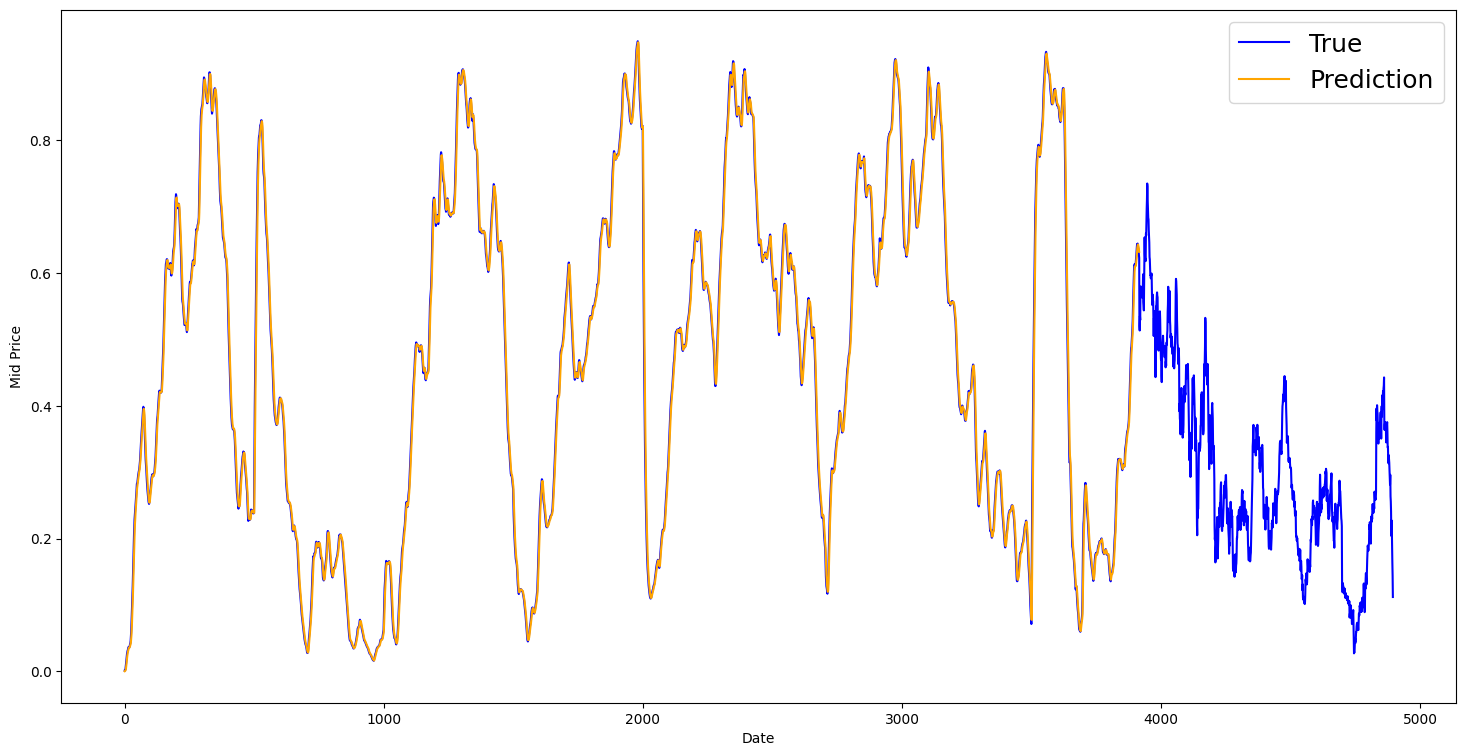

In [13]:

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

As good as the EMA model looks, it isn't as beneficial as it looks. While it is great at predicting one step ahead, it isn't very practical in our use case. Additionally, making predictions in windows greater than just one day exposes the incapabilities of the EMA method as you'll always get the same answer for all future prediction steps.

### Using LSTMs for Time Series Forecasting

Long-short-term memory models are extremely powerful time-series models. They can predict an arbitrary number of steps into the future. An LSTM module (or cell) has 5 essential components, which allow it to model both long-term and short-term data.

- Cell state (ct) - This represents the internal memory of the cell, which stores both short-term memory and long-term memories.
- Hidden state (ht) - This is output state information calculated w.r.t. current input, previous hidden state, and current cell input, which you eventually use to predict the future stock market prices. Additionally, the hidden state can decide to only retrieve short- or long-term memories or both types of memory stored in the cell state to make the next prediction.
- Input gate (it) - Decides how much information from current input flows to the cell state.
- Forget gate (ft) - Decides how much information from the current input and the previous cell state flows into the current cell state.
- Output gate (ot) - Decides how much information from the current cell state flows into the hidden state so that if needed LSTM can only pick the long-term memories or short-term memories and long-term memories.

An LSTM cell looks like this:
   
![LSTM Cell](lstm-cell.png)

The equations for calculating each of these entities are:

- $it = σ(WixXt + Wihht-1 + bi)$
- $\tilde{c}\_t = \sigma(W\_{cx}x\_t + W\_{ch}h_{t-1} + b_c)$
- $f\_t = \sigma(W\_{fx}x\_t + W\_{fh}h_{t-1}+b_f)$
- $c_t = f\_t c\_{t-1} + i_t \tilde{c}_t$
- $o\_t = \sigma(W\_{ox}x\_t + W\_{oh}h_{t-1}+b_o)$
- $h_t = o_t tanh(c_t)$

### Data Generator

We're going to first implement a data generator to train the model. Additionally, to make the model more robust we will not make the output for $x\_t$ always $x\_{t+1}$. Instead we will randomly sample an output from the set $x\_{t+1},x\_{t+2},\ldots,x_{t+N}$ where $N$ is a small window size.

Here, we make the following assumption:

$x\_{t+1},x\_{t+2},\ldots,x_{t+N}$ will not be very far from each other. I personally think this is a reasonable assumption for stock movement predictions.

The below image shows how we'll create a batch of data.

![Data Generator](data-generator.png)

In [14]:

class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [9.0016366e-04 2.0612834e-01 6.7969866e-02 9.0698451e-01 8.3455157e-01]

	Output: [9.0016366e-04 2.1137202e-01 6.7969866e-02 9.0698451e-01 8.3699566e-01]


Unrolled index 1
	Inputs:  [8.1014732e-04 2.1056873e-01 7.0325747e-02 9.1628605e-01 8.3540499e-01]

	Output: [0.01075547 0.20900403 0.08132492 0.91960657 0.835405  ]


Unrolled index 2
	Inputs:  [0.00183972 0.21137202 0.07260833 0.91960657 0.83699566]

	Output: [0.00648199 0.20649236 0.08132492 0.8997113  0.83699566]


Unrolled index 3
	Inputs:  [0.00340932 0.21070313 0.07618813 0.91859996 0.8388723 ]

	Output: [0.01075547 0.20900403 0.08607785 0.9114661  0.85129416]


Unrolled index 4
	Inputs:  [0.00648199 0.20900403 0.08132492 0.9163771  0.8447963 ]

	Output: [0.01075547 0.1939102  0.09519704 0.8885708  0.86919224]


### Defining hyperparameters, inputs and outputs

In [18]:
D = 1 # Dimensionality of the data. Since our data is 1-D this would be 1
num_unrollings = 50 # Number of time steps we look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

train_inputs = [tf.keras.Input(shape=(D,), batch_size=batch_size, name=f'train_inputs_{ui}') for ui in range(num_unrollings)]
train_outputs = [tf.keras.Input(shape=(1,), batch_size=batch_size, name=f'train_outputs_{ui}') for ui in range(num_unrollings)]

### Defining parameters of the LSTM and regression layer

In [ ]:
lstm_cells = [
    tf.keras.layers.LSTMCell(units=num_nodes[li], dropout=dropout)
    for li in range(n_layers)
]

multi_cell = tf.keras.layers.StackedRNNCells(lstm_cells)

initializer = tf.keras.initializers.GlorotUniform()
w = tf.Variable(initializer(shape=[num_nodes[-1], 1]), name='w')
b = tf.Variable(tf.random.uniform([1], -0.1, 0.1), name='b')